In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


 # Experiment 1 

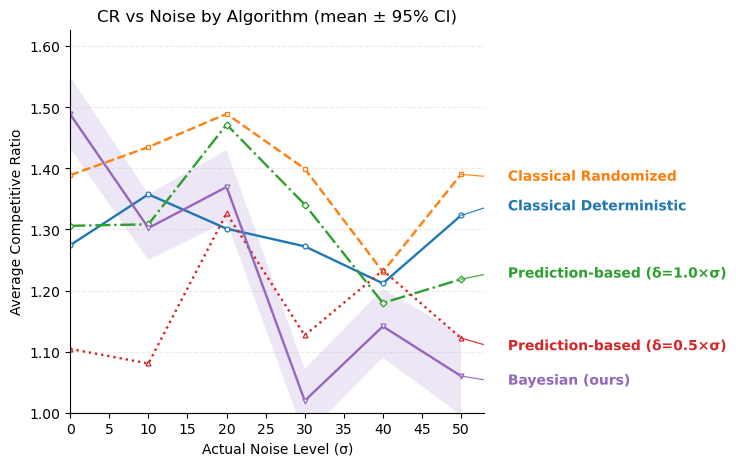

Saved: figs-final/exp1.png


In [ ]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장) — 수평 연장 제거 버전
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 데이터 준비: agg 없으면 샘플 생성 =====
if 'agg' not in globals():
    np.random.seed(0)
    algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    # 일부 알고리즘은 50까지만, 일부는 100까지 만들어 상황 재현
    rows = []
    for algo in algos:
        if algo in ["Classical Deterministic", "Bayesian (ours)"]:
            noise_levels = np.arange(0, 101, 10)   # 0..100
        else:
            noise_levels = np.arange(0, 51, 10)    # 0..50 (이후 없음)

        mean   = 1.05 + 0.45 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high= mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 스타일/순서 =====
order      = agg["algorithm"].unique().tolist()
palette    = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 시작 =====
fig, ax = plt.subplots(figsize=(7.6, 4.8))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].copy()
    if tmp.empty:
        continue

    # 안전: numeric + 정렬
    for col in ["noise", "mean", "ci_low", "ci_high"]:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    tmp = tmp.dropna(subset=["noise", "mean"]).sort_values("noise")

    # >>> 핵심: 패딩/재색인/보간으로 '뒤를 채우지 않음' (수평선 방지)
    x = tmp["noise"].to_numpy()
    y = tmp["mean"].to_numpy()
    lo = tmp["ci_low"].to_numpy()
    hi = tmp["ci_high"].to_numpy()

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 우리 모델만 신뢰구간 음영 (있는 구간까지만)
    if algo == "Bayesian (ours)":
        ax.fill_between(x, lo, hi, alpha=0.16, facecolor=color, edgecolor="none")

    # 모든 모델 라인 + 마커 (있는 구간까지만)
    ax.plot(x, y, linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
            markerfacecolor="white", markeredgewidth=0.9, color=color)

    # 라벨용 끝점 = 실제 마지막 데이터 지점
    x_last = float(x[-1])
    y_last = float(y[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축/눈금/타이틀 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
ax.set_xlim(0, 53)
ax.set_xticks(np.arange(0, 53, 10))
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.xaxis.set_major_locator(MaxNLocator(nbins=11, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 선 끝 라벨링 (충돌 방지) =====
end_points.sort(key=lambda t: t[2])  # y 기준 정렬
yrange  = y_max - y_min
xpad    = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)

lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
    "Bayesian (ours)":               0.0,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 아래→위, 위→아래 스윕
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(x_last + xpad, y_lab, algo, color=color, fontsize=10,
            va='center', ha='left', fontweight='semibold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-final", exist_ok=True)
out_png = "figs-final/exp1.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


# Experiment 2


EXPERIMENT 3 (FIXED RULE): PRIOR MISSPECIFICATION — INTERIOR THRESHOLDS

High Uncertainty (σ/μ≈0.42)
  Params: M=500, b=16, E[T]=120.0, σ=50.0
  Baseline t* = 253 (probe=253), Baseline CR = 7.6184, Cost = 121.831

Medium Uncertainty (σ/μ≈0.33)
  Params: M=300, b=12, E[T]=90.0, σ=30.0
  Baseline t* = 148 (probe=148), Baseline CR = 7.4977, Cost = 89.956

Low Uncertainty (σ/μ≈0.31)
  Params: M=200, b=9, E[T]=65.0, σ=20.0
  Baseline t* = 98 (probe=98), Baseline CR = 7.2405, Cost = 65.161


/var/folders/97/37rhzgks7qzdhsqdg2l1qbyc0000gn/T/ipykernel_85086/447202414.py:255: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  piv = (df2.groupby(["tv_bin", "scenario_type"])["pct_cost_increase"]



Saved:
 - figs-bosun/exp3.csv
 - figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png


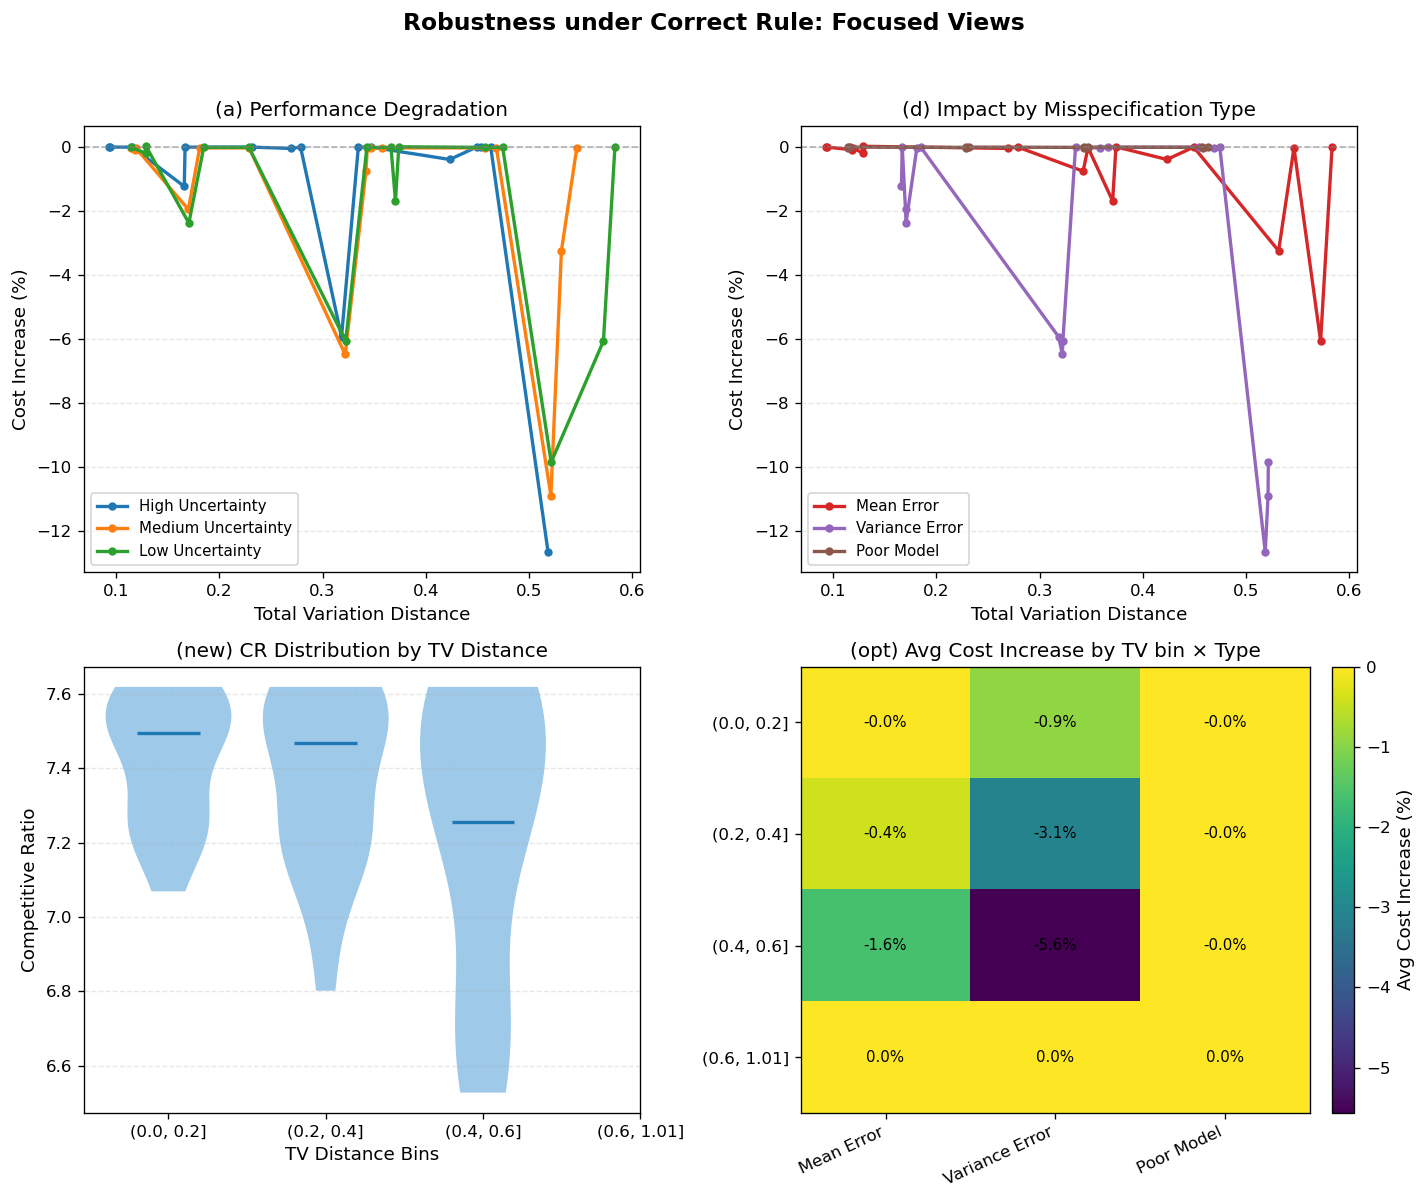

In [ ]:
# =========================================================
# Experiment 3 (FINAL FIX): Prior Misspecification — Interior Thresholds
#  - FIX: Use b <= E[T - t + 1 | T >= t]   (no min-cap)
#  - Auto-pick b so that t* is interior
#  - Produce 3 focused plots
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

RNG = np.random.default_rng(20251112)

# -----------------------
# Priors
# -----------------------
def gaussian_prior(M: int, mean: float, std: float) -> np.ndarray:
    x = np.arange(1, M + 1, dtype=float)
    p = stats.norm.pdf(x, mean, std)
    s = p.sum()
    return p / s if s > 0 else np.ones(M) / M

def uniform_prior(M: int) -> np.ndarray:
    return np.ones(M, dtype=float) / M

# -----------------------
# Correct threshold rule (NO CAP!)
#   Buy at the first t s.t. b <= E[T - t + 1 | T >= t]
# -----------------------

def compute_buy_threshold_tstar(b: int, prior: np.ndarray) -> int:
    """
    Correct Bayesian threshold (no cap). Returns first t s.t. E[T - t + 1 | T >= t] <= b.
    """
    M = prior.size
    P = np.concatenate([[0.0], np.cumsum(prior)])
    W = np.concatenate([[0.0], np.cumsum(prior * np.arange(1, M + 1))])

    for t in range(1, M + 1):
        S_t = P[M] - P[t - 1]
        if S_t <= 0:
            break
        sum_kp = W[M] - W[t - 1]
        sum_p  = P[M] - P[t - 1]
        E_rem  = (sum_kp - (t - 1) * sum_p) / S_t
        #  조건 방향 반대로: 기대 잔여일이 b보다 작거나 같아지면 산다.
        if E_rem <= b:
            return t
    return M + 1


def tv_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return 0.5 * np.abs(p1 - p2).sum()

# -----------------------
# Pick b so that t* lies inside (target ratio)
# -----------------------
def pick_b_for_interior_tstar(M: int, mean: float, std: float,
                              target_range=(0.3, 0.7)):
    """
    Scan b in [1, M] and pick one with t*/(M+1) in target_range.
    """
    prior = gaussian_prior(M, mean, std)
    candidates = []
    for b in range(1, M + 1):
        tstar = compute_buy_threshold_tstar(b, prior)
        ratio = tstar / (M + 1)
        candidates.append((b, tstar, ratio))

    lo, hi = target_range
    in_range = [c for c in candidates if lo <= c[2] <= hi]
    if in_range:
        # 중앙에 가까운 b 선택
        in_range.sort(key=lambda x: abs(x[2] - 0.5*(lo+hi)))
        return in_range[0][0], in_range[0][1]

    # 내부에 없으면 가장 가까운 b 선택
    candidates.sort(key=lambda x: abs(x[2] - 0.5*(lo+hi)))
    b, t, r = candidates[0]
    if r <= 0.05 or r >= 0.95:
        print(f"⚠️ Warning: could not find interior t* for M={M}. Using fallback b≈{mean/3:.1f}")
        b = int(round(mean/3))
        t = compute_buy_threshold_tstar(b, prior)
    return b, t


# -----------------------
# Core experiment
# -----------------------
def run_experiment(n_trials=10000):
    configs = [
        ("High Uncertainty (σ/μ≈0.42)",   500, 120.0, 50.0),
        ("Medium Uncertainty (σ/μ≈0.33)", 300,  90.0, 30.0),
        ("Low Uncertainty (σ/μ≈0.31)",    200,  65.0, 20.0),
    ]

    rows = []

    print("\n" + "="*74)
    print("EXPERIMENT 3 (FIXED RULE): PRIOR MISSPECIFICATION — INTERIOR THRESHOLDS")
    print("="*74)

    for name, M, mu, sigma in configs:
        true_prior = gaussian_prior(M, mu, sigma)

        # b 선택: t*/(M+1) ~ [0.30, 0.70]
        b, t_probe = pick_b_for_interior_tstar(M, mu, sigma, target_range=(0.30, 0.70))

        # 최적(=true prior 기준) 임계치
        t_star_opt = compute_buy_threshold_tstar(b, true_prior)

        # 샘플 고정
        days = np.arange(1, M + 1)
        T_samples = RNG.choice(days, size=n_trials, p=true_prior)

        # baseline cost / CR
        cost_opt  = np.where(T_samples < t_star_opt, T_samples, (t_star_opt - 1) + b).astype(float)
        opt_cost  = np.minimum(T_samples, b).astype(float)
        cr_base   = cost_opt / opt_cost
        base_cost = float(cost_opt.mean())
        base_cr   = float(cr_base.mean())

        print(f"\n{name}")
        print(f"  Params: M={M}, b={b}, E[T]={mu:.1f}, σ={sigma:.1f}")
        print(f"  Baseline t* = {t_star_opt} (probe={t_probe}), Baseline CR = {base_cr:.4f}, Cost = {base_cost:.3f}")

        # 시나리오
        scenarios = []
        # Mean Error
        for shift in [-0.5, -0.3, -0.1, +0.1, +0.3, +0.5]:
            m_mu = float(np.clip(mu * (1 + shift), 2.0, M - 2.0))
            scenarios.append(("Mean Error", shift, gaussian_prior(M, m_mu, sigma)))
        # Variance Error
        for vf in [0.3, 0.5, 0.7, 1.5, 2.5, 4.0]:
            scenarios.append(("Variance Error", vf, gaussian_prior(M, mu, sigma * vf)))
        # Poor Model (mix with uniform)
        U = uniform_prior(M)
        for delta in [0.2, 0.4, 0.6, 0.8]:
            mix = (1 - delta) * true_prior + delta * U
            mix /= mix.sum()
            scenarios.append(("Poor Model", delta, mix))

        for s_type, param, miss_prior in scenarios:
            tv = tv_distance(true_prior, miss_prior)
            t_star = compute_buy_threshold_tstar(b, miss_prior)

            cost = np.where(T_samples < t_star, T_samples, (t_star - 1) + b).astype(float)
            cr   = cost / opt_cost

            avg_cost = float(cost.mean())
            regret   = avg_cost - base_cost
            pct_inc  = 100.0 * regret / base_cost if base_cost > 0 else 0.0

            rows.append({
                "config": name, "M": M, "b": b,
                "scenario_type": s_type, "parameter": param,
                "tv_distance": float(tv),
                "mean_cr": float(cr.mean()),
                "std_cr": float(cr.std(ddof=1)),
                "p95_cr": float(np.percentile(cr, 95)),
                "p99_cr": float(np.percentile(cr, 99)),
                "failure_rate": float(np.mean(cr > 1.5)),
                "severe_fail": float(np.mean(cr > 2.0)),
                "t_star": int(t_star),
                "t_star_optimal": int(t_star_opt),
                "threshold_error": int(t_star - t_star_opt),
                "avg_cost": avg_cost,
                "baseline_cost": base_cost,
                "regret": float(regret),
                "pct_cost_increase": float(pct_inc),
            })

    return pd.DataFrame(rows)

# -----------------------
# Focused 3 plots
# -----------------------
def plot_focused_three(df: pd.DataFrame,
                       tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
                       use_violin=True, add_heatmap=True):
    mpl.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "legend.fontsize": 9,
    })

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axA, axB, axC, axD = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

    # (a) Performance degradation
    ax = axA
    regimes = df["config"].unique().tolist()
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"][:len(regimes)]
    for c, reg in zip(colors, regimes):
        d = df[df["config"] == reg].sort_values("tv_distance")
        ax.plot(d["tv_distance"], d["pct_cost_increase"],
                marker="o", linestyle="-", linewidth=2, ms=4, color=c, label=reg.split(" (")[0])
    ax.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    ax.set_title("(a) Performance Degradation")
    ax.set_xlabel("Total Variation Distance")
    ax.set_ylabel("Cost Increase (%)")
    ax.grid(axis='y', alpha=0.3, linestyle="--")
    ax.legend(frameon=True)

    # (d) Impact by Misspecification Type
    ax = axB
    types = ["Mean Error", "Variance Error", "Poor Model"]
    tcolors = ["#d62728", "#9467bd", "#8c564b"]
    for c, t in zip(tcolors, types):
        d = df[df["scenario_type"] == t].sort_values("tv_distance")
        ax.plot(d["tv_distance"], d["pct_cost_increase"],
                marker="o", linestyle="-", linewidth=2, ms=4, color=c, label=t)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    ax.set_title("(d) Impact by Misspecification Type")
    ax.set_xlabel("Total Variation Distance")
    ax.set_ylabel("Cost Increase (%)")
    ax.grid(axis='y', alpha=0.3, linestyle="--")
    ax.legend(frameon=True)

    # (new) CR Distribution by TV bins  (use mean_cr per row as proxy)
    ax = axC
    bins = pd.IntervalIndex.from_breaks(tv_edges)
    df2 = df.copy()
    df2["tv_bin"] = pd.cut(df2["tv_distance"], bins=bins, include_lowest=True)
    cat = df2["tv_bin"].cat.categories
    labels = [str(iv) for iv in cat]
    series = [df2.loc[df2["tv_bin"] == iv, "mean_cr"].dropna().values for iv in cat]

    pos = np.arange(1, len(labels) + 1)
    if use_violin:
        nonempty = [(p, s) for p, s in zip(pos, series) if s.size > 0]
        if nonempty:
            ppos, pser = zip(*nonempty)
            parts = ax.violinplot(pser, positions=ppos, widths=0.8,
                                  showmeans=False, showmedians=True, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor("#5DA5DA"); pc.set_alpha(0.6)
            if "cmedians" in parts:
                parts["cmedians"].set_linewidth(2.0)
    else:
        ax.boxplot([s if s.size > 0 else np.array([np.nan]) for s in series],
                   positions=pos, widths=0.8, showfliers=False)

    ax.set_title("(new) CR Distribution by TV Distance")
    ax.set_xlabel("TV Distance Bins")
    ax.set_ylabel("Competitive Ratio")
    ax.set_xticks(pos); ax.set_xticklabels(labels)
    ax.grid(axis='y', alpha=0.3, linestyle="--")

    # (opt) Heatmap: Avg cost increase by (tv_bin, type)
    ax = axD
    ax.set_title("(opt) Avg Cost Increase by TV bin × Type")
    piv = (df2.groupby(["tv_bin", "scenario_type"])["pct_cost_increase"]
             .mean()
             .unstack("scenario_type")
             .reindex(index=cat, columns=types))
    mat = piv.fillna(0.0).values
    im = ax.imshow(mat, aspect="auto", cmap="viridis", origin="upper")
    ax.set_yticks(np.arange(len(cat))); ax.set_yticklabels([str(iv) for iv in cat])
    ax.set_xticks(np.arange(len(types))); ax.set_xticklabels(types, rotation=25, ha="right")
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            ax.text(j, i, f"{val:.1f}%", va="center", ha="center",
                    color="white" if val > mat.max()*0.6 else "black", fontsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Avg Cost Increase (%)")

    plt.suptitle("Robustness under Correct Rule: Focused Views", fontsize=14, fontweight="bold", y=0.995)
    fig.tight_layout(rect=[0, 0.0, 1, 0.97])
    return fig

# -----------------------
# Run & Save
# -----------------------
if __name__ == "__main__":
    mpl.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 600,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    os.makedirs("figs-bosun", exist_ok=True)

    df = run_experiment(n_trials=10000)
    df_path = "figs-bosun/exp3.csv"
    df.to_csv(df_path, index=False)

    fig = plot_focused_three(df, tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
                             use_violin=True, add_heatmap=True)
    fig.savefig("figs-bosun/exp3final.png", bbox_inches="tight")

    print("\nSaved:")
    print(" -", df_path)
    # print(" - figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.pdf")
    print(" - figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png")


ValueError: `dataset` input should have multiple elements.

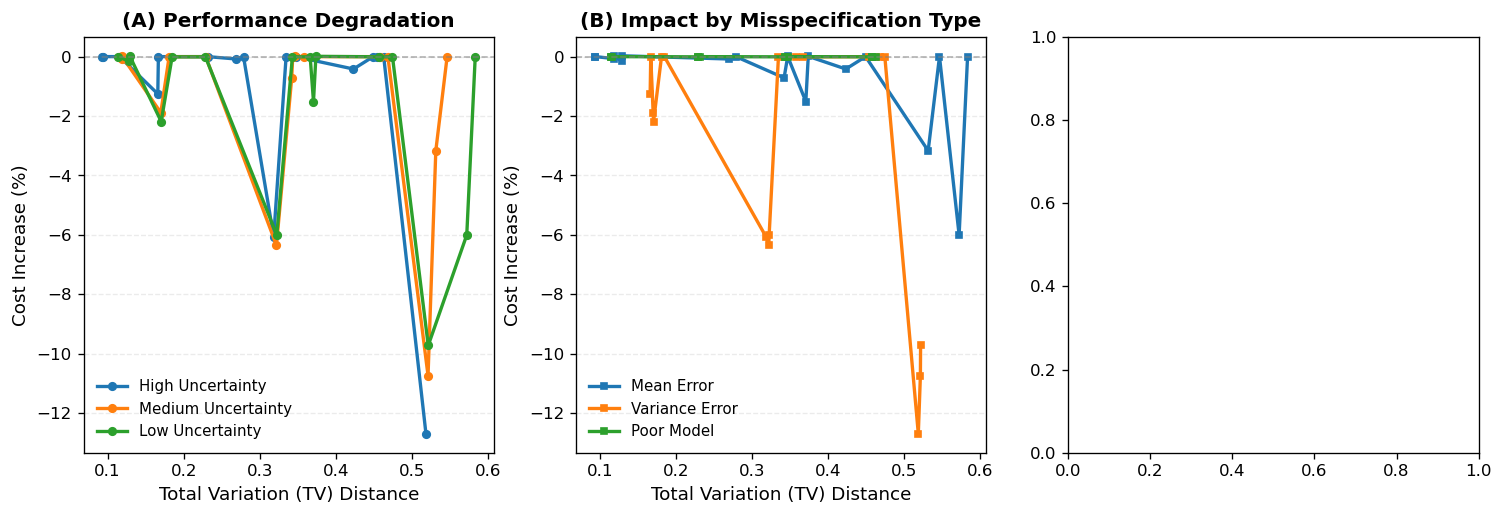

In [41]:
# ===========================
# Focused 3-plot Figure
# ===========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------------------------
# 입력 로딩: df 가 없으면 CSV 읽기
# ---------------------------
if 'df' not in globals():
    df_path = "figs-bosun/exp3.csv"  # 너가 방금 저장한 파일 경로
    df = pd.read_csv(df_path)

# 숫자형 보정(혹시 문자열 섞였을 때 대비)
num_cols = [
    "tv_distance", "pct_cost_increase", "mean_cr", "std_cr", "p95_cr", "p99_cr",
    "failure_rate", "severe_fail", "t_star", "t_star_optimal", "threshold_error",
    "avg_cost", "baseline_cost", "regret"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------------------------
# 헬퍼: 안전한 바이올린/박스플롯
# ---------------------------
def safe_violin(ax, series_list, positions, widths=0.8, use_violin=True):
    """비어있는 bin도 안전하게 처리"""
    data = []
    for s in series_list:
        arr = np.asarray(s, dtype=float)
        arr = arr[np.isfinite(arr)]
        data.append(arr if arr.size > 0 else np.array([np.nan]))

    if use_violin:
        parts = ax.violinplot(
            data, positions=positions, widths=widths,
            showmeans=False, showmedians=True, showextrema=False
        )
        # 스타일
        for pc in parts['bodies']:
            pc.set_alpha(0.25)
        if 'cmedians' in parts:
            parts['cmedians'].set_linewidth(1.5)
        return parts
    else:
        bp = ax.boxplot(
            data, positions=positions, widths=widths,
            showfliers=False, patch_artist=True
        )
        for patch in bp['boxes']:
            patch.set_alpha(0.25)
        return bp

# ---------------------------
# 메인 플로팅 함수
# ---------------------------
def plot_focused_three(
    df,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    use_violin=True,
    outfile="figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png"
):
    # 복사본
    d = df.copy()

    # 1) (A) Performance Degradation — 레짐별
    configs = list(d["config"].dropna().unique())
    configs_sorted = sorted(configs, key=lambda s: ["High", "Medium", "Low"].index(s.split()[0]) if s.startswith(("High","Medium","Low")) else 99)

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15, 4.5))

    # 패널 A
    for cfg in configs_sorted:
        sub = d[d["config"] == cfg].sort_values("tv_distance")
        axA.plot(
            sub["tv_distance"], sub["pct_cost_increase"],
            marker="o", linewidth=2.0, markersize=4.5, label=cfg.split("(")[0].strip()
        )
    axA.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axA.set_title("(A) Performance Degradation", fontweight="bold")
    axA.set_xlabel("Total Variation (TV) Distance")
    axA.set_ylabel("Cost Increase (%)")
    axA.grid(axis="y", alpha=0.25, linestyle="--")
    axA.legend(frameon=False)

    # 2) (B) Impact by Misspecification Type — 타입별
    type_order = ["Mean Error", "Variance Error", "Poor Model"]
    for tp in type_order:
        sub = d[d["scenario_type"] == tp].sort_values("tv_distance")
        axB.plot(
            sub["tv_distance"], sub["pct_cost_increase"],
            marker="s", linewidth=2.0, markersize=4.0, label=tp
        )
    axB.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axB.set_title("(B) Impact by Misspecification Type", fontweight="bold")
    axB.set_xlabel("Total Variation (TV) Distance")
    axB.set_ylabel("Cost Increase (%)")
    axB.grid(axis="y", alpha=0.25, linestyle="--")
    axB.legend(frameon=False)

    # 3) (C) CR Distribution — TV-bin별 분포
    tv_edges = np.asarray(tv_edges, dtype=float)
    tv_labels = [f"[{tv_edges[i]:.1f}, {tv_edges[i+1]:.1f})" for i in range(len(tv_edges) - 1)]
    d["tv_bin"] = pd.cut(d["tv_distance"], bins=tv_edges, labels=tv_labels, include_lowest=True)

    # 바인딩: 각 bin에서 모든 config/타입 조합의 mean_cr을 모아 분포 그림
    bin_series = []
    all_bin_labels = []
    for lbl in tv_labels:
        vals = d.loc[d["tv_bin"] == lbl, "mean_cr"]
        vals = vals[np.isfinite(vals)]
        bin_series.append(vals.values)  # 비어있으면 빈 array
        all_bin_labels.append(lbl)

    positions = np.arange(1, len(all_bin_labels) + 1)
    safe_violin(axC, bin_series, positions, widths=0.9, use_violin=use_violin)

    axC.set_title("(C) Competitive Ratio Distribution", fontweight="bold")
    axC.set_xlabel("TV Distance Bin")
    axC.set_ylabel("Competitive Ratio (CR)")
    axC.set_xticks(positions)
    axC.set_xticklabels(all_bin_labels, rotation=0)
    axC.grid(axis="y", alpha=0.25, linestyle="--")

    # 보기 좋은 y 포맷(정수/한 자리 소수)
    axC.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}" if v < 10 else f"{int(v)}"))

    fig.tight_layout()
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    fig.savefig(outfile, bbox_inches="tight", dpi=300)
    print(f"Saved: {outfile}")
    return fig

# ======================
# 실행 예시
# ======================
fig = plot_focused_three(
    df,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),  # 필요시 조정
    use_violin=True,                      # False로 바꾸면 boxplot
    outfile="figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png"
)


✅ Saved: figs-bosun/exp3_3PLOTS.png (plot type = boxplot)


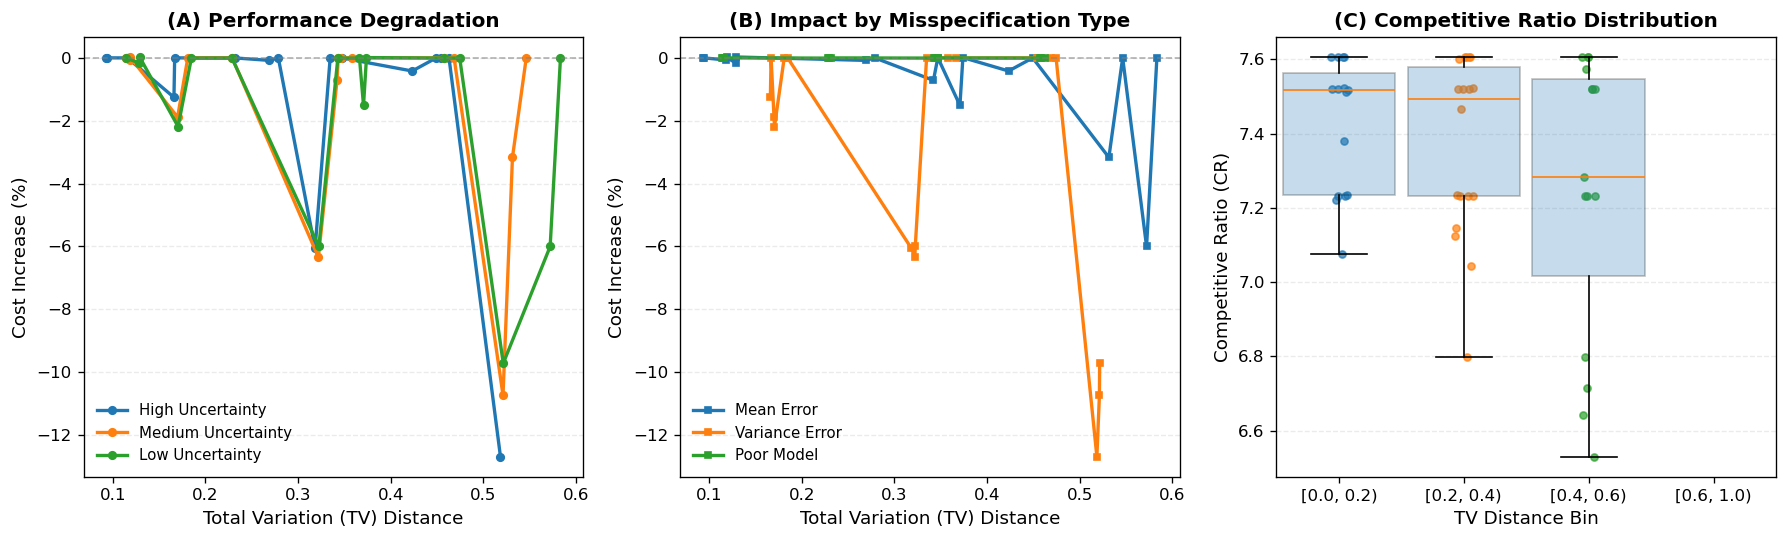

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# === 데이터 로드 ===
if 'df' not in globals():
    df = pd.read_csv("figs-bosun/exp3.csv")

for c in [
    "tv_distance", "pct_cost_increase", "mean_cr", "std_cr", "p95_cr", "p99_cr",
    "failure_rate", "severe_fail", "t_star", "t_star_optimal", "threshold_error",
    "avg_cost", "baseline_cost", "regret"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

def plot_focused_three_safe(
    d,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    outfile="figs-bosun/exp3_FIXEDRULE_FOCUSED_3PLOTS.png"
):
    d = d.copy()
    configs = list(d["config"].dropna().unique())
    order_key = {"High":0, "Medium":1, "Low":2}
    configs_sorted = sorted(configs, key=lambda s: order_key.get(s.split()[0], 99))

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15, 4.6))

    # --- (A) Performance Degradation ---
    for cfg in configs_sorted:
        sub = d[d["config"] == cfg].sort_values("tv_distance")
        axA.plot(
            sub["tv_distance"], sub["pct_cost_increase"],
            marker="o", linewidth=2.0, markersize=4.5,
            label=cfg.split("(")[0].strip()
        )
    axA.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axA.set_title("(A) Performance Degradation", fontweight="bold")
    axA.set_xlabel("Total Variation (TV) Distance")
    axA.set_ylabel("Cost Increase (%)")
    axA.grid(axis="y", alpha=0.25, linestyle="--")
    axA.legend(frameon=False)

    # --- (B) Impact by Type ---
    type_order = ["Mean Error", "Variance Error", "Poor Model"]
    for tp in type_order:
        sub = d[d["scenario_type"] == tp].sort_values("tv_distance")
        if len(sub) > 0:
            axB.plot(
                sub["tv_distance"], sub["pct_cost_increase"],
                marker="s", linewidth=2.0, markersize=4.0,
                label=tp
            )
    axB.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axB.set_title("(B) Impact by Misspecification Type", fontweight="bold")
    axB.set_xlabel("Total Variation (TV) Distance")
    axB.set_ylabel("Cost Increase (%)")
    axB.grid(axis="y", alpha=0.25, linestyle="--")
    axB.legend(frameon=False)

    # --- (C) CR Distribution ---
    tv_edges = np.asarray(tv_edges, dtype=float)
    tv_labels = [f"[{tv_edges[i]:.1f}, {tv_edges[i+1]:.1f})" for i in range(len(tv_edges)-1)]
    d["tv_bin"] = pd.cut(d["tv_distance"], bins=tv_edges, labels=tv_labels, include_lowest=True)

    bin_series = []
    for lbl in tv_labels:
        vals = d.loc[d["tv_bin"] == lbl, "mean_cr"]
        vals = vals[np.isfinite(vals)]
        bin_series.append(vals.values)

    positions = np.arange(1, len(tv_labels) + 1)

    # --- 자동 fallback ---
    safe_data = []
    has_violin = True
    for vals in bin_series:
        arr = np.asarray(vals, dtype=float)
        if arr.size < 2:
            has_violin = False
        safe_data.append(arr if arr.size > 0 else np.array([np.nan, np.nan]))

    if has_violin:
        parts = axC.violinplot(safe_data, positions=positions, widths=0.9,
                               showmeans=False, showmedians=True, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(0.25)
    else:
        bp = axC.boxplot(safe_data, positions=positions, widths=0.9,
                         showfliers=False, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_alpha(0.25)

    # --- scatter로 실제 값 시각화 ---
    rng = np.random.default_rng(42)
    for pos, vals in zip(positions, bin_series):
        if vals.size == 0:
            continue
        x = pos + (rng.random(vals.size) - 0.5) * 0.15
        axC.scatter(x, vals, s=18, alpha=0.7)

    axC.set_title("(C) Competitive Ratio Distribution", fontweight="bold")
    axC.set_xlabel("TV Distance Bin")
    axC.set_ylabel("Competitive Ratio (CR)")
    axC.set_xticks(positions)
    axC.set_xticklabels(tv_labels)
    axC.grid(axis="y", alpha=0.25, linestyle="--")
    axC.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.1f}" if v < 10 else f"{int(v)}"))

    fig.tight_layout()
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    fig.savefig(outfile, bbox_inches="tight", dpi=300)
    print(f"✅ Saved: {outfile} (plot type = {'violin' if has_violin else 'boxplot'})")

    return fig

# === 실행 ===
fig = plot_focused_three_safe(
    df,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    outfile="figs-bosun/exp2final.png"
)
